In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from ipywidgets import interact

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable

import torchvision
from torchvision import transforms

from torchsummary import summary
from PIL import Image

from model import AlexNet, train_one_epoch

In [2]:
cat_dir = './data/Cat/'
dog_dir = './data/Dog/'

cat_image_path = sorted([os.path.join(cat_dir, f) for f in os.listdir(cat_dir)])
dog_image_path = sorted([os.path.join(dog_dir, f) for f in os.listdir(dog_dir)])
print(len(cat_image_path), len(dog_image_path))
print(cat_image_path[0], dog_image_path[0])

251 251
./data/Cat/cat.0.jpg ./data/Dog/dog.0.jpg


In [3]:
image_file_path = [*cat_image_path, *dog_image_path]
correct_image_path = [i for i in image_file_path if cv2.imread(i) is not None]
print(len(correct_image_path))

502


In [4]:
random.seed(29)
random.shuffle(correct_image_path)

train_image_files = correct_image_path[:400]
val_image_files = correct_image_path[400:-10]
test_image_files = correct_image_path[-10:]
print(len(train_image_files), len(val_image_files), len(test_image_files))

400 92 10


In [5]:
@interact(index=(0, len(train_image_files)-1))
def image_show(index=0):
    image = train_image_files[index]
    image = cv2.imread(image)
    print('image shape: ', image.shape)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.title(train_image_files[index].split('/')[-1].split('.')[0])
    plt.imshow(image)
    plt.tight_layout()
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=399), Output()), _dom_classes=('widget-inter…

In [6]:
class build_transform():
    def __init__(self, image_size, mean, std):
        self.transform = {
                    'train':transforms.Compose([
                                                transforms.RandomResizedCrop(image_size, scale=(0.5, 1.0)),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean, std=std)
                    ]),
                    'val':transforms.Compose([
                                                transforms.Resize(image_size),
                                                transforms.CenterCrop(image_size),
                                                transforms.ToTensor(),
                                                transforms.Normalize(mean=mean, std=std)
                    ])
        }
    
    def __call__(self, image, phase):
        return self.transform[phase](image)

In [7]:
class MyDataset(Dataset):
    def __init__(self, file_list, phase='train', transform=None):
        self.file_list = file_list
        self.phase = phase
        self.transform = transform
    
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, index):
        image_path = self.file_list[index]
        image = Image.open(image_path)
        image_transform = self.transform(image, self.phase)

        label = image_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        else: # cat
            label = 0
        
        return image_transform, label

In [8]:
image_size = 256
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cpu')

In [9]:
train_dataset = MyDataset(train_image_files, transform=build_transform(image_size=image_size, mean=mean, std=std), phase='train')
val_dataset = MyDataset(val_image_files, transform=build_transform(image_size=image_size, mean=mean, std=std), phase='val')
test_dataset = MyDataset(test_image_files, transform=build_transform(image_size=image_size, mean=mean, std=std), phase='val')

index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 256, 256])
0


In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
dataloaders = {'train':train_dataloader, 'val':val_dataloader}

images, labels = next(iter(dataloaders['train']))
print(images.size())
print(labels)

torch.Size([32, 3, 256, 256])
tensor([1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 1])


In [11]:
model = AlexNet()
model = model.to(DEVICE)

In [12]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss().to(DEVICE)
summary(model, input_size=(3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 63, 63]          23,296
              ReLU-2           [-1, 64, 63, 63]               0
         MaxPool2d-3           [-1, 64, 31, 31]               0
            Conv2d-4          [-1, 192, 31, 31]         307,392
              ReLU-5          [-1, 192, 31, 31]               0
         MaxPool2d-6          [-1, 192, 15, 15]               0
            Conv2d-7          [-1, 384, 15, 15]         663,936
              ReLU-8          [-1, 384, 15, 15]               0
            Conv2d-9          [-1, 256, 15, 15]         884,992
             ReLU-10          [-1, 256, 15, 15]               0
           Conv2d-11          [-1, 256, 15, 15]         590,080
             ReLU-12          [-1, 256, 15, 15]               0
        MaxPool2d-13            [-1, 256, 7, 7]               0
AdaptiveAvgPool2d-14            [-1, 25

In [14]:
num_epochs = 10
model = train_one_epoch(model, dataloaders, criterion, optimizer, num_epochs, DEVICE)

  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.693589506149292 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6918043286904044 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6938994145393371 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.691996499248173 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6937566995620728 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6922719089881234 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6935499477386474 Acc: 0.485


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.692553504653599 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934566402435303 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6927266276401022 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6934104943275452 Acc: 0.4825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6928330944932025 Acc: 0.5434782608695652


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6931035113334656 Acc: 0.5075


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6930609397266222 Acc: 0.5760869565217391


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6933370327949524 Acc: 0.4825


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935106826865155 Acc: 0.45652173913043476


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.693241286277771 Acc: 0.4925


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6935943987058557 Acc: 0.45652173913043476


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss: 0.6930774664878845 Acc: 0.4875


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss: 0.6938721978146097 Acc: 0.45652173913043476


TypeError: unsupported operand type(s) for -: 'float' and 'builtin_function_or_method'

In [15]:
id_list = []
pred_list = []
_id = 0

with torch.no_grad():
    for test_path in tqdm(test_image_files):
        image = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = build_transform(image_size, mean, std)
        image = transform(image, phase='val')
        image = image.unsqueeze(0)
        image = image.to(DEVICE)

        model.eval()
        out = model(image)
        preds = F.softmax(out, dim=1)[:, 1].tolist()

        id_list.append(_id)
        pred_list.append(preds[0])

res = pd.DataFrame({
    'id':id_list,
    'label':pred_list
})
res.to_csv('Alexnet.csv', index=False)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
res

,id,label
0,74,0.496289
1,107,0.496086
2,138,0.496269
3,230,0.495734
4,151,0.496320
5,36,0.496141
6,148,0.495900
7,32,0.496546
8,132,0.495431
9,124,0.495610


In [21]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image(image_file_path, predicted_labels=(), cols=5):
    rows = len(image_file_path) // cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 6))

    for i, image_file in enumerate(image_file_path):
        image = cv2.imread(image_file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        a = random.choice(res['id'].values)
        label = res.loc[res['id'] == a, 'label'].values[0]

        if label > 0.496:
            label = 1
        else:
            label = 0

        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(class_[label])
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

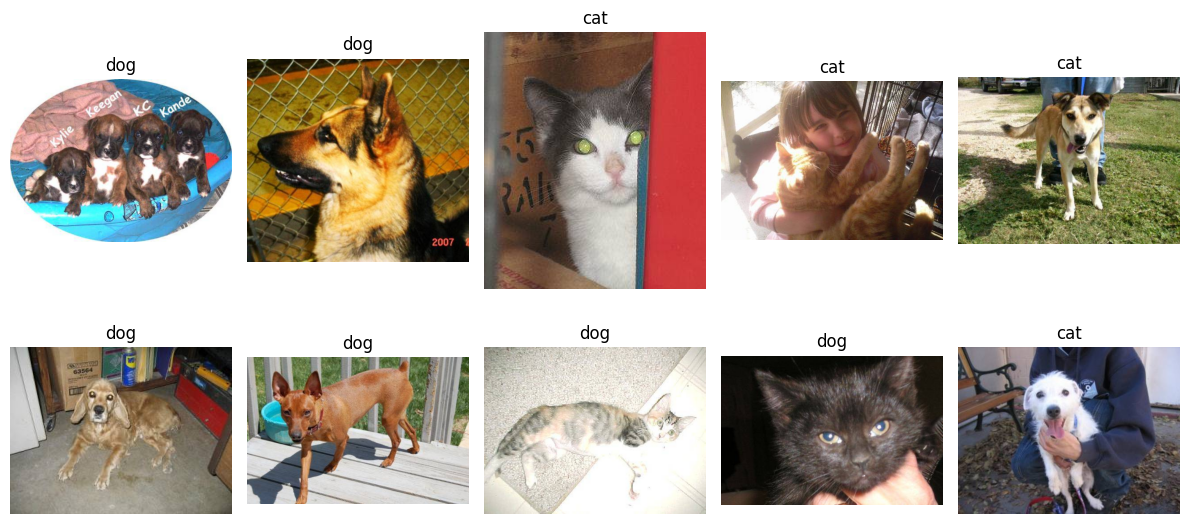

In [22]:
display_image(test_image_files)